In [1]:
import multiprocessing
multiprocessing.set_start_method("fork")

import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
%matplotlib inline

from prophet import Prophet

In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
%aimport prophet_projpred
%aimport prophet_projpred.models
%aimport prophet_projpred.family

In [4]:
df = pd.read_csv('data/ecuador_dataset.csv')
df['date']=pd.to_datetime(df['date'])
df = df.loc[
    df['family'].isin(
        ['BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DELI', 'GROCERY I', 'MEATS', 'PERSONAL CARE', 'POULTRY', 'PRODUCE']),
    ['family', 'date', 'unit_sales', 'onpromotion', 'oil_price', 'precipitation', 
     'tavg', 'tmax', 'tmin', 'yellow maize', 'potatoes']
]
df = df.groupby(by='date').agg(
    unit_sales = pd.NamedAgg(column='unit_sales', aggfunc='sum'),
    onpromotion = pd.NamedAgg(column='onpromotion', aggfunc='sum'),
    oil_price = pd.NamedAgg(column='oil_price', aggfunc='first'),
    precipitation = pd.NamedAgg(column='precipitation', aggfunc='first'),
    tmax = pd.NamedAgg(column='tmax', aggfunc='first'),
    tmin = pd.NamedAgg(column='tmin', aggfunc='first'),
    tavg = pd.NamedAgg(column='tavg', aggfunc='first'),
    yellow_maize = pd.NamedAgg(column='yellow maize', aggfunc='first'),
    potatoes = pd.NamedAgg(column='potatoes', aggfunc='first')
)
df = df.rename(columns={'unit_sales': 'y'})
df = df.rename_axis('ds')
df[['y', 'onpromotion']] = np.log(df[['y', 'onpromotion']])

train = df.loc['2015-05-01':'2017-04-30',:].reset_index()
future = df.loc['2015-05-01':'2017-06-30',:].reset_index()

future

,ds,y,onpromotion,oil_price,precipitation,tmax,tmin,tavg,yellow_maize,potatoes
0,2015-05-01,12.508238,7.664816,59.10,0.0,20.300000,4.066667,13.950000,21.766667,0.295333
1,2015-05-02,12.606216,6.190315,59.10,0.0,21.000000,3.700000,13.400000,21.783333,0.295667
2,2015-05-03,12.677281,6.180017,59.10,20.1,21.000000,6.000000,11.300000,21.800000,0.296000
3,2015-05-04,12.323003,6.068426,58.92,16.0,19.000000,5.300000,12.100000,21.816667,0.296333
4,2015-05-05,12.197967,6.059123,60.38,8.9,20.100000,6.800000,11.900000,21.833333,0.296667
...,...,...,...,...,...,...,...,...,...,...
783,2017-06-26,12.583300,7.859027,43.24,0.0,18.520000,7.000000,12.920000,17.961667,0.274667
784,2017-06-27,12.430620,8.023880,44.25,0.0,18.466667,7.066667,12.933333,17.990000,0.276000
785,2017-06-28,12.574611,8.740177,44.74,0.0,18.413333,7.133333,12.946667,18.018333,0.277333
786,2017-06-29,12.367607,8.013674,44.88,0.0,18.360000,7.200000,12.960000,18.046667,0.278667


In [5]:
holidays = pd.read_csv('data/holidays_events.csv', parse_dates=['date'])
holidays = holidays[holidays['locale_name'].isin(['Quito', 'Ecuador'])]
holidays = holidays.sort_values(by=['description', 'date']).reset_index()
holidays = holidays[['date', 'description']].rename(columns={'date': 'ds', 'description': 'holiday'})
holidays

,ds,holiday
0,2013-05-24,Batalla de Pichincha
1,2014-05-24,Batalla de Pichincha
2,2015-05-24,Batalla de Pichincha
3,2016-05-24,Batalla de Pichincha
4,2017-05-24,Batalla de Pichincha
...,...,...
182,2013-04-29,Viernes Santo
183,2014-04-18,Viernes Santo
184,2015-04-03,Viernes Santo
185,2016-03-25,Viernes Santo


In [26]:
m = prophet_projpred.ReferenceModel(changepoint_prior_scale=0.01, holidays=holidays, mcmc_samples=400, uncertainty_samples=800)

In [27]:
m.add_seasonality(name='yearly', period=365.25, fourier_order=8, prior_scale=10)
m.add_seasonality(name='monthly', period=30.5, fourier_order=8, prior_scale=10)
m.add_seasonality(name='weekly', period=7, fourier_order=5, prior_scale=10)
m.add_regressor('onpromotion')
m.add_regressor('oil_price')
m.add_regressor('precipitation')
m.add_regressor('tavg')
m.add_regressor('tmax')
m.add_regressor('tmin')
m.add_regressor('potatoes')
m.add_regressor('yellow_maize')

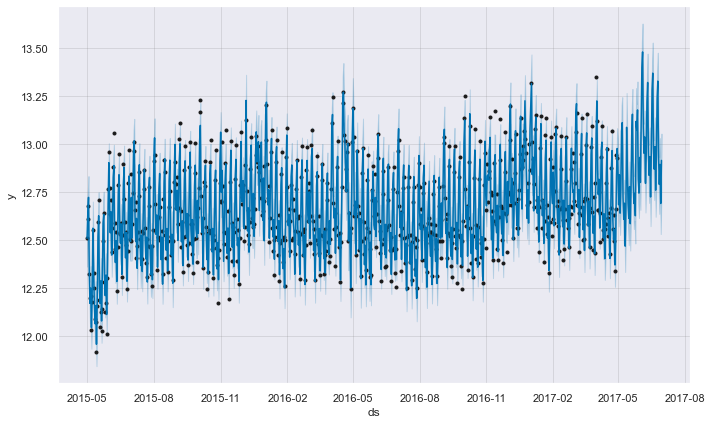

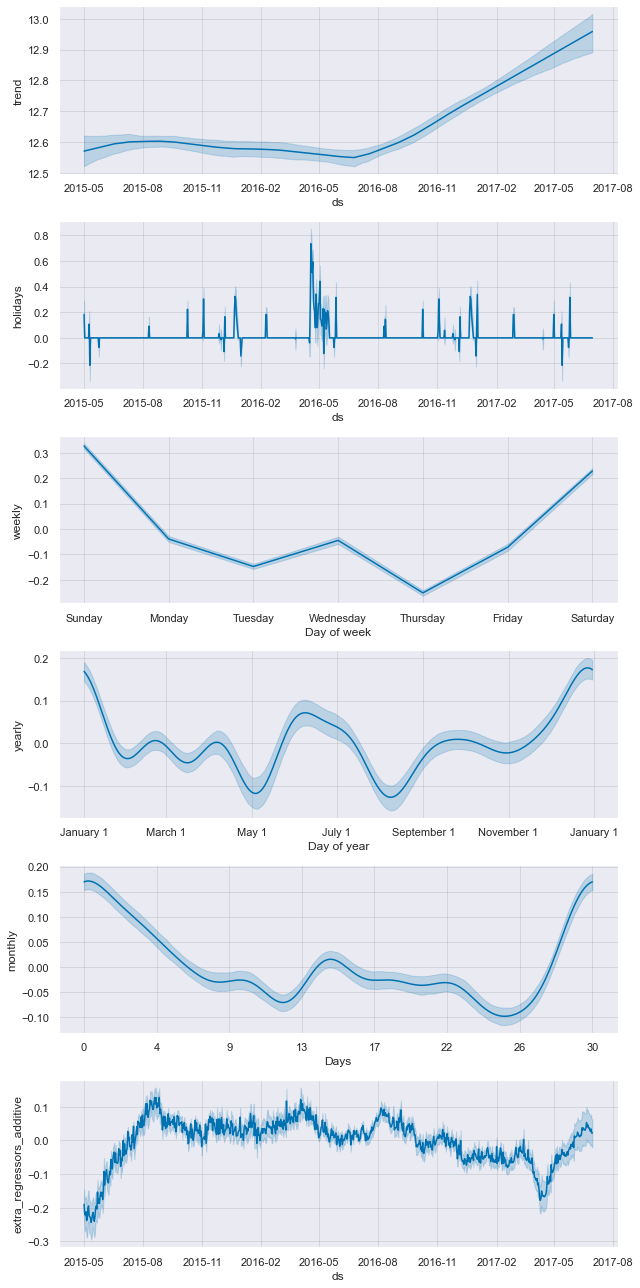

In [29]:
m.fit(train)
forecast = m.predict(future)

fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [10]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='365.25 days', period='60 days', horizon = '30 days')

  0%|          | 0/6 [00:00<?, ?it/s]

In [11]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-06-05,13.086586,12.973520,13.205978,13.051267,2016-06-04
1,2016-06-06,12.654000,12.537784,12.762578,12.599696,2016-06-04
2,2016-06-07,12.506502,12.389473,12.626132,12.429871,2016-06-04
3,2016-06-08,12.553745,12.432403,12.680144,12.546527,2016-06-04
4,2016-06-09,12.332017,12.200662,12.461019,12.286601,2016-06-04
...,...,...,...,...,...,...
174,2017-04-26,12.402850,12.261461,12.532772,12.627005,2017-03-31
175,2017-04-27,12.198812,12.065576,12.329023,12.337720,2017-03-31
176,2017-04-28,12.346511,12.205903,12.488732,12.658976,2017-03-31
177,2017-04-29,12.653267,12.517373,12.793954,12.939686,2017-03-31


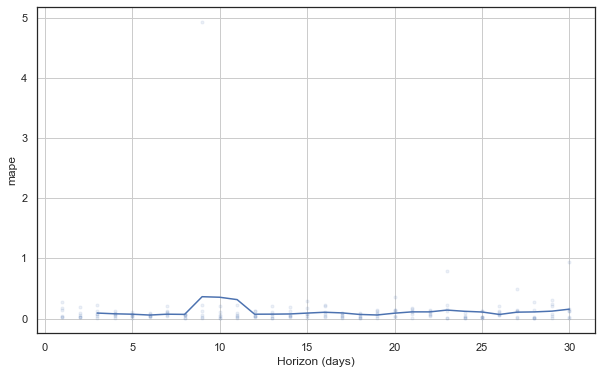

In [115]:
from prophet.plot import plot_cross_validation_metric

exp_df_cv = df_cv.copy()
exp_df_cv[['yhat', 'yhat_lower', 'yhat_upper', 'y']] = np.exp(exp_df_cv[['yhat', 'yhat_lower', 'yhat_upper', 'y']])
with sns.axes_style('white'):
    fig = plot_cross_validation_metric(exp_df_cv, metric='mape')

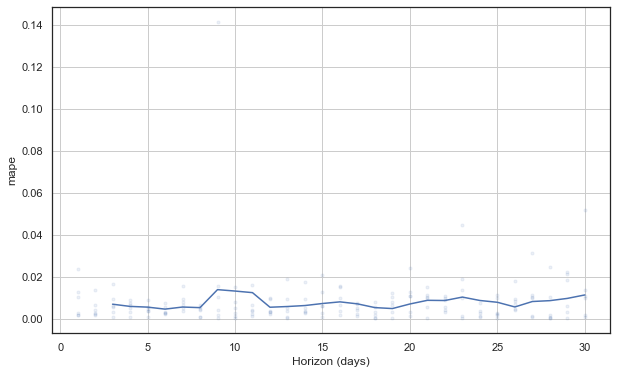

In [116]:
with sns.axes_style('white'):
    fig = plot_cross_validation_metric(df_cv, metric='mape')

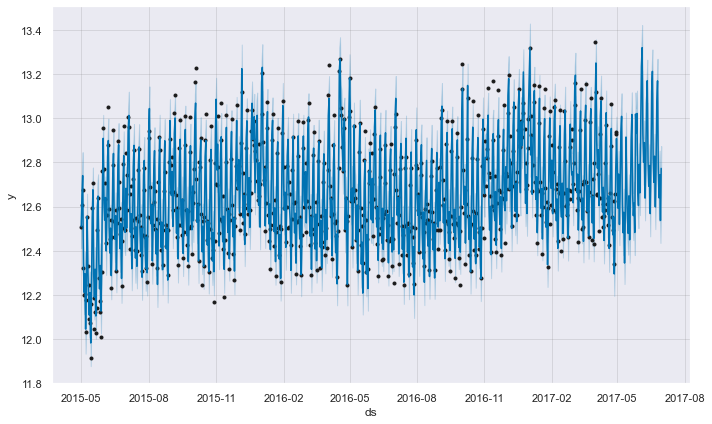

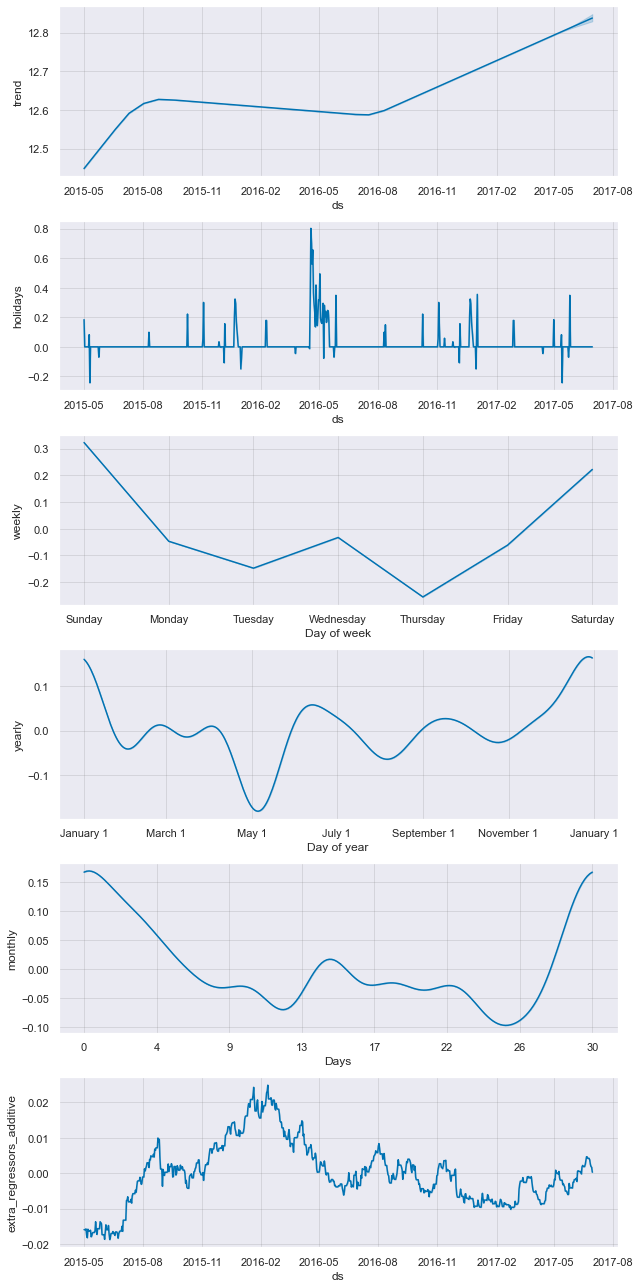

In [72]:
submodel = m.projection_model(['oil_price', 'tavg'])
submodel.fit(train)
forecast = submodel.predict(future)

fig1 = submodel.plot(forecast)
fig2 = submodel.plot_components(forecast)

In [117]:
pred_indices = future.index.values > m.history.index.max()
predictions = forecast.loc[
    pred_indices, 'yhat'].values
actual = future.loc[pred_indices, 'y'].values
mape = np.mean(np.abs((actual - predictions)/actual))
mape

0.017806114578853633

In [96]:
predictions

array([12.79717294, 12.59308698, 12.74770291, 12.51913885, 12.68298435,
       12.93761386, 13.00924625, 12.60893509, 12.48166984, 12.5743887 ,
       12.34428566, 12.54601798, 12.91553243, 12.67714867, 12.54357616,
       12.47854508, 12.64885622, 12.44953234, 12.62868349, 12.90400061,
       13.01772374, 12.658021  , 12.55907631, 12.61604958, 12.48276832,
       13.01947839, 12.93204528, 13.02234848, 12.6669493 , 12.60486329,
       12.79180052, 12.66254073, 12.93107261, 13.23609556, 13.32040254,
       12.92693291, 12.80090424, 12.89020295, 12.63854806, 12.80669965,
       13.07259638, 13.1706843 , 12.80507541, 12.69251305, 12.78620138,
       12.56826435, 12.8044706 , 13.12222916, 13.21315354, 12.81723765,
       12.71027364, 12.82884356, 12.59847031, 12.78512269, 13.07329944,
       13.16991725, 12.77226013, 12.63978299, 12.74464005, 12.53721436,
       12.7732917 ])

In [97]:
actual

array([13.18315395, 12.75912816, 12.7977085 , 12.50874774, 12.66861974,
       12.94105941, 13.10278967, 12.63321914, 12.48512438, 12.58302408,
       12.34849764, 12.60516271, 12.98839922, 12.74267879, 12.62417466,
       12.61613505, 12.7058631 , 12.37789545, 12.62869468, 12.9274345 ,
       13.10667444, 12.61815271, 12.50203338, 12.58162195, 12.35266247,
       12.87207628, 12.80306832, 12.95775042, 12.59243193, 12.5308632 ,
       12.69268551, 12.5963534 , 12.83062659, 13.08655994, 13.25837198,
       12.80171022, 12.61550996, 12.73562943, 12.42993334, 12.66740027,
       12.91126089, 13.11616692, 12.61041809, 12.52915178, 12.62591768,
       12.44229852, 12.73066688, 12.99521566, 12.84585831, 12.63758547,
       12.64866469, 12.62028069, 12.3625605 , 12.61573562, 12.87526188,
       12.99620938, 12.58329993, 12.43062005, 12.57461092, 12.36760652,
       12.68169673])

In [94]:
m.predictive_samples_mean(future)

,ds,yhat
0,2015-05-01,12.507977
1,2015-05-02,12.634273
2,2015-05-03,12.721033
3,2015-05-04,12.333668
4,2015-05-05,12.169351
...,...,...
783,2017-06-26,12.926841
784,2017-06-27,12.788466
785,2017-06-28,12.892449
786,2017-06-29,12.689272


In [96]:
m.predictive_samples(future)

{'yhat':            0          1          2          3          4          5    \
 0    12.526019  12.476129  12.554273  12.470568  12.585093  12.607919   
 1    12.653637  12.557357  12.638386  12.640022  12.646119  12.715399   
 2    12.700300  12.676581  12.728025  12.724061  12.736783  12.799501   
 3    12.314683  12.306965  12.370716  12.350373  12.323159  12.390857   
 4    12.148680  12.144450  12.191132  12.181920  12.169002  12.212870   
 ..         ...        ...        ...        ...        ...        ...   
 783  12.996953  12.943874  12.917855  13.009517  12.876745  12.875264   
 784  12.817836  12.813469  12.797861  12.864166  12.735122  12.718624   
 785  12.911464  12.880689  12.925480  12.960081  12.853526  12.842205   
 786  12.713390  12.652024  12.675944  12.717900  12.651631  12.634741   
 787  12.944511  12.884875  12.902219  12.962816  12.866348  12.864113   
 
            6          7          8          9    ...        790        791  \
 0    12.574286  12.416

In [117]:
path = m.search(train, future)

        variable        kl
0   yellow_maize  0.162667
1      oil_price  1.025950
2           tavg  1.168463
3           tmax  1.508993
4  precipitation  1.637034
5    onpromotion  1.701768
6           tmin  1.758867
7       potatoes  1.804120
        variable        kl
0      oil_price  0.116368
1           tavg  0.134562
2           tmax  0.162798
3           tmin  0.170908
4  precipitation  0.175946
5       potatoes  0.180733
6    onpromotion  0.188615
        variable        kl
0           tavg  0.070961
1           tmax  0.103614
2  precipitation  0.123991
3           tmin  0.125457
4       potatoes  0.127263
5    onpromotion  0.127569
        variable        kl
0  precipitation  0.026410
1    onpromotion  0.045722
2           tmax  0.075712
3           tmin  0.076983
4       potatoes  0.078153
      variable        kl
0  onpromotion  0.009132
1         tmin  0.023404
2     potatoes  0.025197
3         tmax  0.025596
   variable        kl
0      tmax  0.001144
1  potatoes  0.006889

In [118]:
path

{1: {'variables': ['yellow_maize'],
  'predictions':             0          1          2          3          4          5   \
  0    12.526009  12.545679  12.417205  12.557689  12.555224  12.481265   
  1    12.643917  12.634058  12.662349  12.611306  12.597085  12.612278   
  2    12.715261  12.723431  12.753566  12.710106  12.697170  12.734975   
  3    12.305168  12.342545  12.361345  12.303446  12.297922  12.378068   
  4    12.168209  12.182719  12.224404  12.196740  12.171865  12.270840   
  ..         ...        ...        ...        ...        ...        ...   
  783  12.926731  12.864469  12.783765  12.832526  12.939312  12.872580   
  784  12.754715  12.703422  12.649764  12.731405  12.801722  12.749268   
  785  12.850976  12.822725  12.768521  12.835123  12.898826  12.844792   
  786  12.652917  12.638763  12.580251  12.636279  12.687811  12.647842   
  787  12.892849  12.877275  12.816801  12.866378  12.944008  12.877692   
  
              6          7          8         

In [116]:
mapes = [step['mape'] for step in path.values()]
mapes

[0.015186432889594046,
 0.015719457989941777,
 0.017273762786687488,
 0.01661589107105091,
 0.015688425493466496,
 0.016146962288159032,
 0.01610293846153196,
 0.01591520129136335]

In [119]:
elpds = [step['elpd'] for step in path.values()]
elpds

[-2887.637413593768,
 -2878.368863152904,
 -2855.497973639611,
 -2863.60494905723,
 -2874.807986340657,
 -2868.8711149756,
 -2869.8885759975583,
 -2872.356274487446]

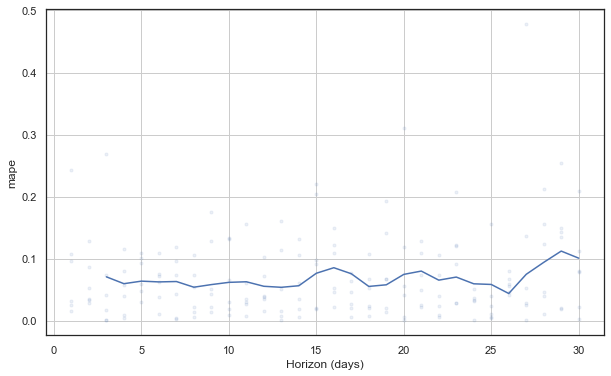

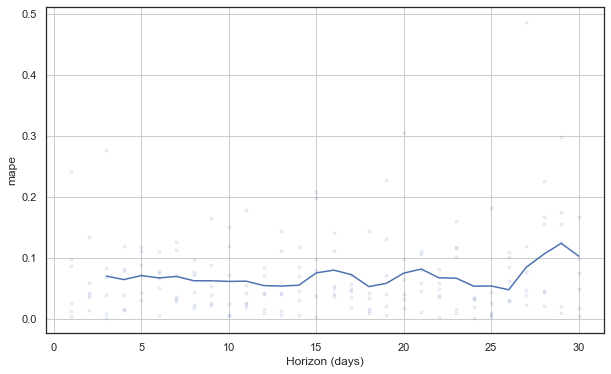

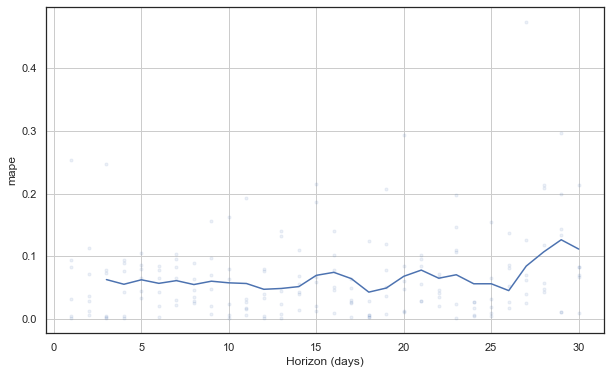

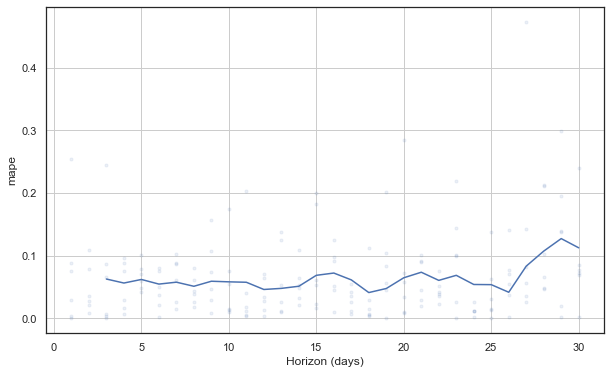

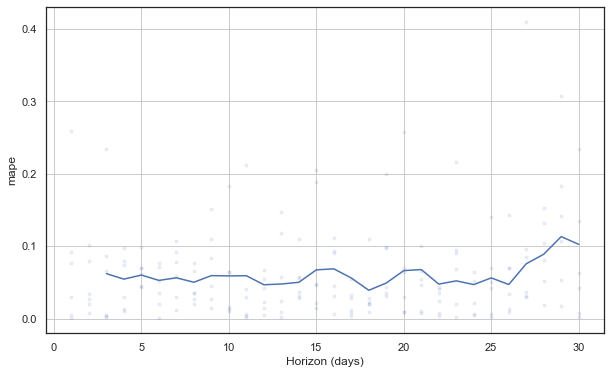

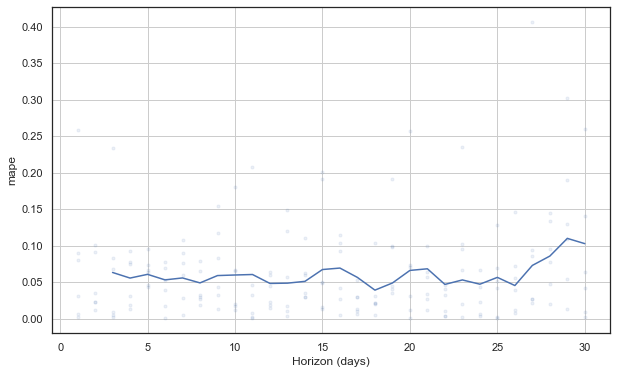

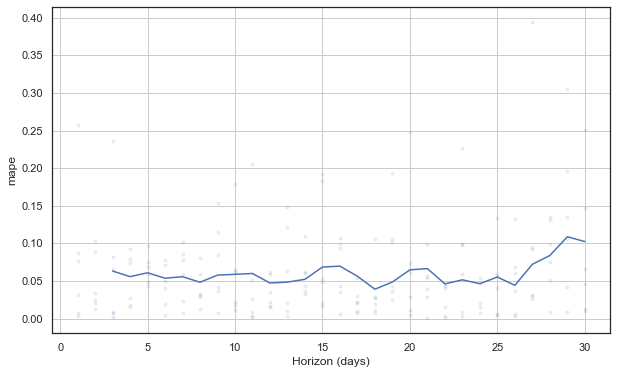

In [23]:
from prophet.plot import plot_cross_validation_metric
for cv in validations:
    exp_cv = cv.copy()
    exp_cv[['yhat', 'yhat_lower', 'yhat_upper', 'y']] = np.exp(exp_cv[['yhat', 'yhat_lower', 'yhat_upper', 'y']])
    #Measure performance relative to the original data (not reference predictions)
    exp_cv[['y']]=np.exp(df_cv[['y']])
    with sns.axes_style('white'):
        fig = plot_cross_validation_metric(exp_cv, metric='mape')